In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import argparse
import copy
from tqdm import tqdm
from statistics import mean, stdev
from sklearn import metrics

import torch
import json
from tree_ring.inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
import open_clip
from tree_ring.optim_utils import *
from tree_ring.io_utils import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import re
def extract_id(string):
    match = re.search(r'sent(\d+)_frames', string)
    if match:
        return match.group(1)
    else:
        return None

/root/miniconda3/envs/integrate/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
parser = argparse.ArgumentParser(description='diffusion watermark')
parser.add_argument('--model_id', default='/root/.cache/huggingface/diffusers/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/')
parser.add_argument('--test_num_inference_steps', default=None, type=int)
parser.add_argument('--num_inference_steps', default=50, type=int)

# watermark
parser.add_argument('--w_mask_shape', default='circle')

parser.add_argument('--w_measurement', default='l1_complex')
parser.add_argument('--w_radius', default=10)
parser.add_argument('--w_channel', default=0, type=int)


# for image distortion

parser.add_argument('--orig_img_no_w_path',default='../datas/videos/text2video-zero/dynamic_radius/8frames_uniform' ,type=str)
parser.add_argument('--orig_img_w_path',default='../datas/videos/text2video-zero/dynamic_radius/8frames_uniform_w', type=str)
parser.add_argument('--radius_path',default='../datas/videos/text2video-zero/dynamic_radius/test/radius', type=str)

args = parser.parse_args([])

if args.test_num_inference_steps is None:
    args.test_num_inference_steps = args.num_inference_steps

In [4]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_id, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
    args.model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision='fp16',
    )
pipe = pipe.to(device)

/root/miniconda3/envs/integrate/lib/python3.9/site-packages/safetensors/torch.py:98: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:


In [5]:
tester_prompt = '' # assume at the detection time, the original prompt is unknown
text_embeddings = pipe.get_text_embedding(tester_prompt)

# ground-truth patch
gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)
init_latents_w = pipe.get_random_latents()
watermarking_mask = get_watermarking_mask(init_latents_w, args, device)
no_w_metrics=[]
w_metrics=[]

/tmp/ipykernel_1469378/301511426.py:5: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  gt_patch = torch.load('./tree_ring/key.pt').to(dtype=torch.complex32)


In [6]:
folders_no_w = os.listdir(args.orig_img_no_w_path)
folders_w = os.listdir(args.orig_img_w_path)
for video in tqdm(folders_no_w[:100]):
    frames = os.listdir(os.path.join(args.orig_img_no_w_path,video))
    id = extract_id(video)
    for idx_frame in range(len(frames)):
        frame = frames[idx_frame]
        frame_path_no_w = os.path.join(args.orig_img_no_w_path, video, frame)
        frame_path_w = os.path.join(args.orig_img_w_path, video, frame)
        
        img_no_w = Image.open(frame_path_no_w)
        img_w = Image.open(frame_path_w)
        
        img_no_w = transform_img(img_no_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        img_w = transform_img(img_w).unsqueeze(0).to(text_embeddings.dtype).to(device)
        
        image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)
        image_latents_w = pipe.get_image_latents(img_w, sample=False)
        
        reversed_latents_no_w = pipe.forward_diffusion(
        latents=image_latents_no_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=args.test_num_inference_steps,
        )
        
        reversed_latents_w = pipe.forward_diffusion(
        latents=image_latents_w,
        text_embeddings=text_embeddings,
        guidance_scale=1,
        num_inference_steps=args.test_num_inference_steps,
        )
        with open(args.radius_path+'/'+id+'_w.json', 'r') as file:
            json_data = file.read()

        dic_radius = json.loads(json_data)
        args.w_radius = dic_radius[str(idx_frame)]
        watermarking_mask = get_watermarking_mask(init_latents_w, args, device)
        no_w_metric, w_metric = eval_watermark(reversed_latents_no_w, reversed_latents_w, watermarking_mask, gt_patch, args)
        no_w_metrics.append(-no_w_metric)
        w_metrics.append(-w_metric)

100%|██████████| 100/100 [40:30<00:00, 24.31s/it]


In [7]:
preds = no_w_metrics +  w_metrics
t_labels = [0] * len(no_w_metrics) + [1] * len(w_metrics)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.5331250000000001


In [8]:
# 分割原始列表，每8个元素为一组
split_lists_no = [no_w_metrics[i:i+8] for i in range(0, len(no_w_metrics), 8)]

# 计算每组的平均值
average_values_no = [sum(sub_list) / len(sub_list) for sub_list in split_lists_no]

# 分割原始列表，每8个元素为一组
split_lists_w = [w_metrics[i:i+8] for i in range(0, len(w_metrics), 8)]

# 计算每组的平均值
average_values_w = [sum(sub_list) / len(sub_list) for sub_list in split_lists_w]

In [9]:
preds = average_values_no +  average_values_w
t_labels = [0] * len(average_values_no) + [1] * len(average_values_w)
fpr, tpr, thresholds = metrics.roc_curve(t_labels, preds, pos_label=1)
auc = metrics.auc(fpr, tpr)
acc = np.max(1 - (fpr + (1 - tpr))/2)
low = tpr[np.where(fpr<.01)[0][-1]]
print(acc)

0.5700000000000001


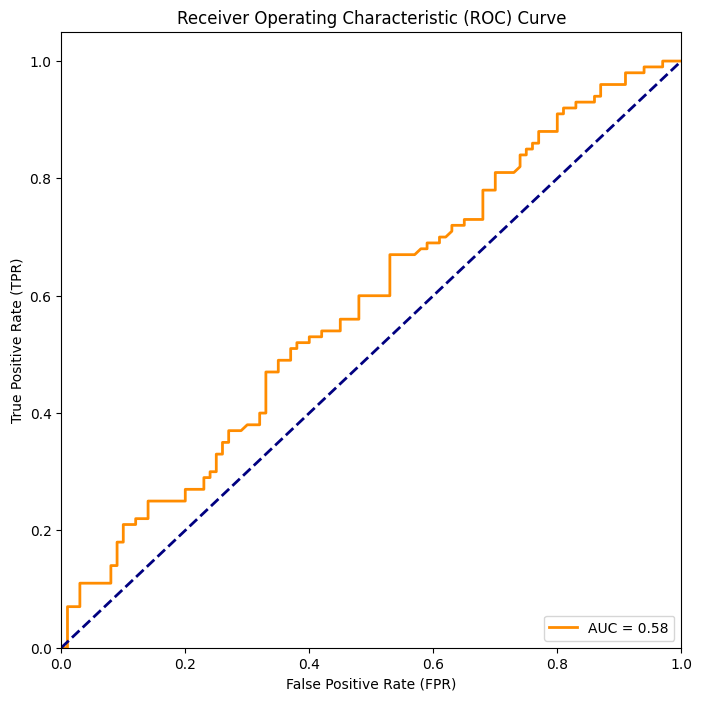

In [10]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()